<a href="https://colab.research.google.com/github/funpi89/NLP_marathon/blob/main/word2vec%E9%AB%98%E9%80%9F%E5%8C%96_%E4%BD%9C%E6%A5%AD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 作業目的: 透過實作加速版word2vec Skip-gram模型來更加了解高速版的word2vec

本次作業會採用Penn Tree Bank資料及，學員可以在ptb.train.txt中取得訓練文本資料。這次作業可以讓學員練習到以pytorch搭建模型與進行文本資料的前處理

PS: 建議學員使用Colab (或可以使用GPU加速的機器)來進行作業，不然訓練會訓練到天荒地老.....

### Connect to Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Necessary Libraries

In [2]:
import os
import re
import tqdm
import random
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import urllib.request
from typing import List
from collections import Counter
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [3]:
# 讀取資料

# Penn Tree Back dataset
with open("/content/drive/MyDrive/NLPMarathon/ptb.train.txt", encoding='utf-8') as f:
    lines = f.readlines()
    
print(f"Total {len(lines)} lines")
raw_dataset = [line.split() for line in lines]

Total 42068 lines


In [4]:
# 查看前5筆
raw_dataset[:5]

[['aer',
  'banknote',
  'berlitz',
  'calloway',
  'centrust',
  'cluett',
  'fromstein',
  'gitano',
  'guterman',
  'hydro-quebec',
  'ipo',
  'kia',
  'memotec',
  'mlx',
  'nahb',
  'punts',
  'rake',
  'regatta',
  'rubens',
  'sim',
  'snack-food',
  'ssangyong',
  'swapo',
  'wachter'],
 ['pierre',
  '<unk>',
  'N',
  'years',
  'old',
  'will',
  'join',
  'the',
  'board',
  'as',
  'a',
  'nonexecutive',
  'director',
  'nov.',
  'N'],
 ['mr.',
  '<unk>',
  'is',
  'chairman',
  'of',
  '<unk>',
  'n.v.',
  'the',
  'dutch',
  'publishing',
  'group'],
 ['rudolph',
  '<unk>',
  'N',
  'years',
  'old',
  'and',
  'former',
  'chairman',
  'of',
  'consolidated',
  'gold',
  'fields',
  'plc',
  'was',
  'named',
  'a',
  'nonexecutive',
  'director',
  'of',
  'this',
  'british',
  'industrial',
  'conglomerate'],
 ['a',
  'form',
  'of',
  'asbestos',
  'once',
  'used',
  'to',
  'make',
  'kent',
  'cigarette',
  'filters',
  'has',
  'caused',
  'a',
  'high',
  'percen

In [5]:
# 定義資料前處理函示
class PreProcessor():
    '''Function to do preprocess of input corpus
    Parameters
    -----------
    corpus: str
        input corpus to be processed
    only_word: bool
        whether to filter out non-word
    min_freq: int
        minimum frequency of a word to be kept
    do_subsampling: bool
        whether to do subsampling
    '''
    
    def __init__(self, only_word: bool=False, min_freq: int=5, do_subsampling: bool=True, t: float=1e-5):
        self.only_word = only_word
        self.min_freq = min_freq
        self.do_subsampling = do_subsampling
        self.t = t
    
    def process(self, corpus: List[str]):
        
        word_dic = set()
        counter = Counter()
        processed_sentence = []
        
        for sentence in corpus:
        
            # hint: 請計算字詞頻率
            counter.update(sentence)
            processed_sentence.append(sentence)
        # hint: 移除頻率過小的字詞 建立word2idx與idx2word與word_frequency辭典
        word_cnt = dict(filter(lambda x: x[1] > self.min_freq, counter.items()))
        self.word2idx = {word: idx for idx, word in enumerate(word_cnt.keys(), 0)}
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}
        self.word_frequency = word_cnt.copy()
        
        #將文本轉為ID型式與移除文本中頻率過小的文字
        self.processed_corpus = [[self.word2idx[word] for word in line if word in self.word2idx] for line in processed_sentence]
        self.total_num_words = sum([len(line) for line in self.processed_corpus])
        print(f"Before subsampling: {self.total_num_words} words")
        
        # 進行二次採樣(subsampling)
        if self.do_subsampling:
            self.processed_corpus = [[idx for idx in line if not self.subsampling(idx)] for line in self.processed_corpus]
            self.total_num_words = sum([len(line) for line in self.processed_corpus])
            counter = Counter([self.idx2word[idx] for line in self.processed_corpus for idx in line])
            word_cnt = dict(counter.items())
            self.word_frequency = word_cnt.copy()
            print(f"After subsampling: {self.total_num_words} words")
        
        # hint: 移除空字串
        self.processed_corpus = [[idx for idx in line] for line in self.processed_corpus if len(line) != 0]
        
        return self.processed_corpus, self.word2idx, self.idx2word, self.word_frequency, self.total_num_words
    
    def subsampling(self, idx):
        
        # hint: 學員可以參考講義的subsampling公式(也可自己定義一個)
        p = self.t / self.word_frequency[self.idx2word[idx]] * self.total_num_words
        p_w = math.sqrt(p) + p
        return random.uniform(0, 1) < p_w


# 進行資料前處理
# 這邊我們subsampling的t取1e-4
pre_processor = PreProcessor(True, 5, True, 1e-4)
corpus, word2idx, idx2word, word2freq, total_num_words = pre_processor.process(raw_dataset)

Before subsampling: 885720 words
After subsampling: 448741 words


### 定義Skip-gram使用的Dataset與collate function

In [6]:
# 客製化Dataset
class SkipGramGetAllDataset(Dataset):
    
    def __init__(self, corpus, word2freq, word2idx, idx2word, window_size, num_negatives):
        self.corpus = corpus
        self.word2freq = word2freq
        self.word2idx = word2idx
        self.idx2word = idx2word
        self.window_size = window_size
        self.num_negatives = num_negatives
        
        self.all_targets, self.all_contexts = self._get_all_contexts_targets()
        self.all_negatives = self._get_all_negatives()
        
    def __len__(self):
        return len(self.all_targets)
    
    def __getitem__(self, idx):
        
        # hint: 這裡我們會返回 目標字詞，上下文，負採樣樣本
        return (self.all_targets[idx], self.all_contexts[idx], self.all_negatives[idx])
        
    
    def _get_all_contexts_targets(self):
        all_targets = []
        all_contexts = []
        
        for line in self.corpus:
            if len(line) < 2*self.window_size + 1:
                continue
            
            # hint: 這邊我們要創建上下文 (考慮window_size)
            all_contexts += line[self.window_size:-self.window_size]
            
            for index in range(self.window_size, len(line) - self.window_size):
                # hint: 創建目標字詞
                indices = list(range(max(0, index - self.window_size), min(len(line), index + self.window_size + 1)))
                indices.remove(index)
                all_targets.append([line[idx] for idx in indices])
                               
        return all_targets, all_contexts
                               
    
    def _get_all_negatives(self):
        
        # hint: 進行負採樣，若沒頭緒的學員可以參考實作範例
        
        cur_exists_words = list(self.word2freq.keys())
        sampling_weights = [self.word2freq[word]**0.75 for word in self.word2freq]
        population = list(range(len(sampling_weights)))
        
        all_negatives = []
        neg_candidate = []
        i = 0
        for targets in self.all_targets:
            negatives = []
            while len(negatives) < self.num_negatives:
                if i == len(neg_candidate):
                    neg_candidate = random.choices(population, sampling_weights, k=int(1e5))
                    neg_candidate = list(map(lambda x: self.word2idx[cur_exists_words[x]], neg_candidate))
                    i = 0
                
                if neg_candidate[i] not in targets:
                    negatives.append(neg_candidate[i])
                i += 1
            all_negatives.append(negatives)      
        
        return all_negatives
    
# 客製化collate_fn
def skipgram_collate(data):
    contexts = []
    target_negative = []
    labels = []
    for target, context, negative in data:
        # hint: 將目標字詞、上下文與負採樣樣本個別打包
        target_negative += [target + negative]
        labels += [[1] * len(target) + [0] * len(negative)]
        contexts += [context]
    
    return torch.tensor(contexts), torch.tensor(target_negative), torch.tensor(labels)

### 定義Skip-gram模型

In [7]:
class SkipGram(nn.Module):
    
    def __init__(self, vocab_size, embed_size):
        super(SkipGram, self).__init__()
        
        self.in_embedding = nn.Embedding(vocab_size, embed_size)
        self.out_embedding = nn.Embedding(vocab_size, embed_size)
        
    def forward(self, contexts, targets):
        v = self.in_embedding(contexts)
        u = self.out_embedding(targets)
        
        # do dot product to get output
        pred = torch.matmul(v[:,None,:], u.permute(0,2,1))
        
        return pred.squeeze(dim=1)

### 訓練

In [8]:
# Define hyperparameters

use_cuda = torch.cuda.is_available()
verbose = True
num_epochs = 100
batch_size = 512
embed_size = 100
lr = 0.01

model = SkipGram(len(word2idx), embed_size)
if use_cuda:
    model.cuda()
    
criterion = nn.BCEWithLogitsLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=lr)
dataset = SkipGramGetAllDataset(corpus, word2freq, word2idx, idx2word, 1, 5)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=skipgram_collate)

In [9]:
# Start training

lst_loss = []
model.train()
for epc in tqdm.tqdm(range(num_epochs)):
    batch_loss = 0

    for i, (contexts, target_negative, labels) in enumerate(loader, 1):
        # hint: 開始訓練前要先將optimizer的梯度歸零
        
        optimizer.zero_grad()
        
        if use_cuda:
            contexts = contexts.cuda()
            target_negative = target_negative.cuda()
            labels = labels.cuda()
        
        pred = model(contexts, target_negative)
        loss = criterion(pred.float(), labels.float())
        batch_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        if i % 500 == 0:
            print(f"Epoch: {epc + 1}/{num_epochs}, Batch: {i+1}/{len(dataset)/batch_size} Loss: {batch_loss / i:.5f}")
    
    if verbose:
        print(f"Epoch: {epc + 1}/{num_epochs}, Loss: {batch_loss / i:.5f}")
    
    lst_loss.append(batch_loss/i)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1/100, Batch: 501/714.939453125 Loss: 1.05061


  1%|          | 1/100 [00:02<04:22,  2.66s/it]

Epoch: 1/100, Loss: 0.91762
Epoch: 2/100, Batch: 501/714.939453125 Loss: 0.55356


  2%|▏         | 2/100 [00:04<04:07,  2.53s/it]

Epoch: 2/100, Loss: 0.55003
Epoch: 3/100, Batch: 501/714.939453125 Loss: 0.52705


  3%|▎         | 3/100 [00:07<03:55,  2.43s/it]

Epoch: 3/100, Loss: 0.52675
Epoch: 4/100, Batch: 501/714.939453125 Loss: 0.51818


  4%|▍         | 4/100 [00:09<03:54,  2.44s/it]

Epoch: 4/100, Loss: 0.51828
Epoch: 5/100, Batch: 501/714.939453125 Loss: 0.51243


  5%|▌         | 5/100 [00:11<03:46,  2.38s/it]

Epoch: 5/100, Loss: 0.51282
Epoch: 6/100, Batch: 501/714.939453125 Loss: 0.50848


  6%|▌         | 6/100 [00:14<03:41,  2.35s/it]

Epoch: 6/100, Loss: 0.50928
Epoch: 7/100, Batch: 501/714.939453125 Loss: 0.50591


  7%|▋         | 7/100 [00:16<03:40,  2.37s/it]

Epoch: 7/100, Loss: 0.50672
Epoch: 8/100, Batch: 501/714.939453125 Loss: 0.50410


  8%|▊         | 8/100 [00:18<03:37,  2.36s/it]

Epoch: 8/100, Loss: 0.50487
Epoch: 9/100, Batch: 501/714.939453125 Loss: 0.50266


  9%|▉         | 9/100 [00:21<03:33,  2.35s/it]

Epoch: 9/100, Loss: 0.50352
Epoch: 10/100, Batch: 501/714.939453125 Loss: 0.50170


 10%|█         | 10/100 [00:23<03:33,  2.37s/it]

Epoch: 10/100, Loss: 0.50272
Epoch: 11/100, Batch: 501/714.939453125 Loss: 0.50078


 11%|█         | 11/100 [00:25<03:27,  2.33s/it]

Epoch: 11/100, Loss: 0.50213
Epoch: 12/100, Batch: 501/714.939453125 Loss: 0.50070


 12%|█▏        | 12/100 [00:28<03:21,  2.30s/it]

Epoch: 12/100, Loss: 0.50164
Epoch: 13/100, Batch: 501/714.939453125 Loss: 0.49999


 13%|█▎        | 13/100 [00:30<03:22,  2.33s/it]

Epoch: 13/100, Loss: 0.50121
Epoch: 14/100, Batch: 501/714.939453125 Loss: 0.49983


 14%|█▍        | 14/100 [00:32<03:17,  2.29s/it]

Epoch: 14/100, Loss: 0.50080
Epoch: 15/100, Batch: 501/714.939453125 Loss: 0.49984


 15%|█▌        | 15/100 [00:34<03:12,  2.27s/it]

Epoch: 15/100, Loss: 0.50078
Epoch: 16/100, Batch: 501/714.939453125 Loss: 0.49932


 16%|█▌        | 16/100 [00:37<03:13,  2.30s/it]

Epoch: 16/100, Loss: 0.50056
Epoch: 17/100, Batch: 501/714.939453125 Loss: 0.49963


 17%|█▋        | 17/100 [00:39<03:11,  2.30s/it]

Epoch: 17/100, Loss: 0.50049
Epoch: 18/100, Batch: 501/714.939453125 Loss: 0.49917


 18%|█▊        | 18/100 [00:41<03:08,  2.30s/it]

Epoch: 18/100, Loss: 0.50024
Epoch: 19/100, Batch: 501/714.939453125 Loss: 0.49910


 19%|█▉        | 19/100 [00:44<03:06,  2.30s/it]

Epoch: 19/100, Loss: 0.50021
Epoch: 20/100, Batch: 501/714.939453125 Loss: 0.49886


 20%|██        | 20/100 [00:46<03:01,  2.27s/it]

Epoch: 20/100, Loss: 0.50008
Epoch: 21/100, Batch: 501/714.939453125 Loss: 0.49912


 21%|██        | 21/100 [00:48<02:57,  2.25s/it]

Epoch: 21/100, Loss: 0.50004
Epoch: 22/100, Batch: 501/714.939453125 Loss: 0.49933


 22%|██▏       | 22/100 [00:50<02:57,  2.28s/it]

Epoch: 22/100, Loss: 0.49996
Epoch: 23/100, Batch: 501/714.939453125 Loss: 0.49866


 23%|██▎       | 23/100 [00:53<02:53,  2.25s/it]

Epoch: 23/100, Loss: 0.49993
Epoch: 24/100, Batch: 501/714.939453125 Loss: 0.49837


 24%|██▍       | 24/100 [00:55<02:54,  2.30s/it]

Epoch: 24/100, Loss: 0.49983
Epoch: 25/100, Batch: 501/714.939453125 Loss: 0.49853


 25%|██▌       | 25/100 [00:57<02:54,  2.33s/it]

Epoch: 25/100, Loss: 0.49969
Epoch: 26/100, Batch: 501/714.939453125 Loss: 0.49842


 26%|██▌       | 26/100 [01:00<02:54,  2.36s/it]

Epoch: 26/100, Loss: 0.49966
Epoch: 27/100, Batch: 501/714.939453125 Loss: 0.49890


 27%|██▋       | 27/100 [01:02<02:52,  2.36s/it]

Epoch: 27/100, Loss: 0.49968
Epoch: 28/100, Batch: 501/714.939453125 Loss: 0.49856


 28%|██▊       | 28/100 [01:05<02:52,  2.40s/it]

Epoch: 28/100, Loss: 0.49959
Epoch: 29/100, Batch: 501/714.939453125 Loss: 0.49853


 29%|██▉       | 29/100 [01:07<02:45,  2.34s/it]

Epoch: 29/100, Loss: 0.49959
Epoch: 30/100, Batch: 501/714.939453125 Loss: 0.49844


 30%|███       | 30/100 [01:09<02:40,  2.30s/it]

Epoch: 30/100, Loss: 0.49959
Epoch: 31/100, Batch: 501/714.939453125 Loss: 0.49839


 31%|███       | 31/100 [01:11<02:40,  2.32s/it]

Epoch: 31/100, Loss: 0.49951
Epoch: 32/100, Batch: 501/714.939453125 Loss: 0.49830


 32%|███▏      | 32/100 [01:14<02:38,  2.33s/it]

Epoch: 32/100, Loss: 0.49944
Epoch: 33/100, Batch: 501/714.939453125 Loss: 0.49855


 33%|███▎      | 33/100 [01:16<02:36,  2.34s/it]

Epoch: 33/100, Loss: 0.49943
Epoch: 34/100, Batch: 501/714.939453125 Loss: 0.49811


 34%|███▍      | 34/100 [01:18<02:34,  2.34s/it]

Epoch: 34/100, Loss: 0.49940
Epoch: 35/100, Batch: 501/714.939453125 Loss: 0.49838


 35%|███▌      | 35/100 [01:21<02:30,  2.32s/it]

Epoch: 35/100, Loss: 0.49937
Epoch: 36/100, Batch: 501/714.939453125 Loss: 0.49826


 36%|███▌      | 36/100 [01:23<02:25,  2.28s/it]

Epoch: 36/100, Loss: 0.49932
Epoch: 37/100, Batch: 501/714.939453125 Loss: 0.49810


 37%|███▋      | 37/100 [01:25<02:22,  2.27s/it]

Epoch: 37/100, Loss: 0.49937
Epoch: 38/100, Batch: 501/714.939453125 Loss: 0.49817


 38%|███▊      | 38/100 [01:28<02:23,  2.31s/it]

Epoch: 38/100, Loss: 0.49932
Epoch: 39/100, Batch: 501/714.939453125 Loss: 0.49810


 39%|███▉      | 39/100 [01:30<02:18,  2.28s/it]

Epoch: 39/100, Loss: 0.49925
Epoch: 40/100, Batch: 501/714.939453125 Loss: 0.49845


 40%|████      | 40/100 [01:32<02:15,  2.26s/it]

Epoch: 40/100, Loss: 0.49925
Epoch: 41/100, Batch: 501/714.939453125 Loss: 0.49813


 41%|████      | 41/100 [01:34<02:16,  2.32s/it]

Epoch: 41/100, Loss: 0.49926
Epoch: 42/100, Batch: 501/714.939453125 Loss: 0.49830


 42%|████▏     | 42/100 [01:37<02:17,  2.36s/it]

Epoch: 42/100, Loss: 0.49922
Epoch: 43/100, Batch: 501/714.939453125 Loss: 0.49795


 43%|████▎     | 43/100 [01:39<02:15,  2.38s/it]

Epoch: 43/100, Loss: 0.49924
Epoch: 44/100, Batch: 501/714.939453125 Loss: 0.49816


 44%|████▍     | 44/100 [01:42<02:16,  2.43s/it]

Epoch: 44/100, Loss: 0.49921
Epoch: 45/100, Batch: 501/714.939453125 Loss: 0.49787


 45%|████▌     | 45/100 [01:44<02:10,  2.37s/it]

Epoch: 45/100, Loss: 0.49920
Epoch: 46/100, Batch: 501/714.939453125 Loss: 0.49815


 46%|████▌     | 46/100 [01:46<02:06,  2.34s/it]

Epoch: 46/100, Loss: 0.49917
Epoch: 47/100, Batch: 501/714.939453125 Loss: 0.49798


 47%|████▋     | 47/100 [01:49<02:06,  2.39s/it]

Epoch: 47/100, Loss: 0.49911
Epoch: 48/100, Batch: 501/714.939453125 Loss: 0.49792


 48%|████▊     | 48/100 [01:51<02:04,  2.39s/it]

Epoch: 48/100, Loss: 0.49918
Epoch: 49/100, Batch: 501/714.939453125 Loss: 0.49814


 49%|████▉     | 49/100 [01:54<01:59,  2.35s/it]

Epoch: 49/100, Loss: 0.49912
Epoch: 50/100, Batch: 501/714.939453125 Loss: 0.49800


 50%|█████     | 50/100 [01:56<01:58,  2.37s/it]

Epoch: 50/100, Loss: 0.49917
Epoch: 51/100, Batch: 501/714.939453125 Loss: 0.49840


 51%|█████     | 51/100 [01:58<01:54,  2.34s/it]

Epoch: 51/100, Loss: 0.49919
Epoch: 52/100, Batch: 501/714.939453125 Loss: 0.49782


 52%|█████▏    | 52/100 [02:01<01:52,  2.33s/it]

Epoch: 52/100, Loss: 0.49906
Epoch: 53/100, Batch: 501/714.939453125 Loss: 0.49794


 53%|█████▎    | 53/100 [02:03<01:50,  2.36s/it]

Epoch: 53/100, Loss: 0.49909
Epoch: 54/100, Batch: 501/714.939453125 Loss: 0.49775


 54%|█████▍    | 54/100 [02:05<01:47,  2.35s/it]

Epoch: 54/100, Loss: 0.49905
Epoch: 55/100, Batch: 501/714.939453125 Loss: 0.49833


 55%|█████▌    | 55/100 [02:08<01:44,  2.32s/it]

Epoch: 55/100, Loss: 0.49909
Epoch: 56/100, Batch: 501/714.939453125 Loss: 0.49830


 56%|█████▌    | 56/100 [02:10<01:42,  2.33s/it]

Epoch: 56/100, Loss: 0.49910
Epoch: 57/100, Batch: 501/714.939453125 Loss: 0.49838


 57%|█████▋    | 57/100 [02:12<01:39,  2.31s/it]

Epoch: 57/100, Loss: 0.49915
Epoch: 58/100, Batch: 501/714.939453125 Loss: 0.49778


 58%|█████▊    | 58/100 [02:14<01:36,  2.30s/it]

Epoch: 58/100, Loss: 0.49904
Epoch: 59/100, Batch: 501/714.939453125 Loss: 0.49792


 59%|█████▉    | 59/100 [02:17<01:34,  2.31s/it]

Epoch: 59/100, Loss: 0.49909
Epoch: 60/100, Batch: 501/714.939453125 Loss: 0.49784


 60%|██████    | 60/100 [02:19<01:30,  2.27s/it]

Epoch: 60/100, Loss: 0.49912
Epoch: 61/100, Batch: 501/714.939453125 Loss: 0.49787


 61%|██████    | 61/100 [02:21<01:27,  2.25s/it]

Epoch: 61/100, Loss: 0.49907
Epoch: 62/100, Batch: 501/714.939453125 Loss: 0.49794


 62%|██████▏   | 62/100 [02:24<01:27,  2.31s/it]

Epoch: 62/100, Loss: 0.49902
Epoch: 63/100, Batch: 501/714.939453125 Loss: 0.49783


 63%|██████▎   | 63/100 [02:26<01:24,  2.27s/it]

Epoch: 63/100, Loss: 0.49898
Epoch: 64/100, Batch: 501/714.939453125 Loss: 0.49764


 64%|██████▍   | 64/100 [02:28<01:20,  2.24s/it]

Epoch: 64/100, Loss: 0.49899
Epoch: 65/100, Batch: 501/714.939453125 Loss: 0.49799


 65%|██████▌   | 65/100 [02:30<01:19,  2.28s/it]

Epoch: 65/100, Loss: 0.49902
Epoch: 66/100, Batch: 501/714.939453125 Loss: 0.49743


 66%|██████▌   | 66/100 [02:33<01:17,  2.28s/it]

Epoch: 66/100, Loss: 0.49901
Epoch: 67/100, Batch: 501/714.939453125 Loss: 0.49802


 67%|██████▋   | 67/100 [02:35<01:14,  2.26s/it]

Epoch: 67/100, Loss: 0.49898
Epoch: 68/100, Batch: 501/714.939453125 Loss: 0.49810


 68%|██████▊   | 68/100 [02:37<01:14,  2.31s/it]

Epoch: 68/100, Loss: 0.49896
Epoch: 69/100, Batch: 501/714.939453125 Loss: 0.49801


 69%|██████▉   | 69/100 [02:40<01:11,  2.32s/it]

Epoch: 69/100, Loss: 0.49893
Epoch: 70/100, Batch: 501/714.939453125 Loss: 0.49804


 70%|███████   | 70/100 [02:42<01:08,  2.29s/it]

Epoch: 70/100, Loss: 0.49898
Epoch: 71/100, Batch: 501/714.939453125 Loss: 0.49791


 71%|███████   | 71/100 [02:44<01:06,  2.30s/it]

Epoch: 71/100, Loss: 0.49893
Epoch: 72/100, Batch: 501/714.939453125 Loss: 0.49778


 72%|███████▏  | 72/100 [02:46<01:04,  2.29s/it]

Epoch: 72/100, Loss: 0.49890
Epoch: 73/100, Batch: 501/714.939453125 Loss: 0.49799


 73%|███████▎  | 73/100 [02:49<01:01,  2.26s/it]

Epoch: 73/100, Loss: 0.49900
Epoch: 74/100, Batch: 501/714.939453125 Loss: 0.49779


 74%|███████▍  | 74/100 [02:51<01:00,  2.33s/it]

Epoch: 74/100, Loss: 0.49894
Epoch: 75/100, Batch: 501/714.939453125 Loss: 0.49775


 75%|███████▌  | 75/100 [02:53<00:57,  2.29s/it]

Epoch: 75/100, Loss: 0.49890
Epoch: 76/100, Batch: 501/714.939453125 Loss: 0.49741


 76%|███████▌  | 76/100 [02:55<00:54,  2.27s/it]

Epoch: 76/100, Loss: 0.49891
Epoch: 77/100, Batch: 501/714.939453125 Loss: 0.49816


 77%|███████▋  | 77/100 [02:58<00:53,  2.32s/it]

Epoch: 77/100, Loss: 0.49893
Epoch: 78/100, Batch: 501/714.939453125 Loss: 0.49772


 78%|███████▊  | 78/100 [03:00<00:51,  2.33s/it]

Epoch: 78/100, Loss: 0.49898
Epoch: 79/100, Batch: 501/714.939453125 Loss: 0.49792


 79%|███████▉  | 79/100 [03:03<00:48,  2.30s/it]

Epoch: 79/100, Loss: 0.49898
Epoch: 80/100, Batch: 501/714.939453125 Loss: 0.49797


 80%|████████  | 80/100 [03:05<00:46,  2.33s/it]

Epoch: 80/100, Loss: 0.49888
Epoch: 81/100, Batch: 501/714.939453125 Loss: 0.49800


 81%|████████  | 81/100 [03:07<00:43,  2.30s/it]

Epoch: 81/100, Loss: 0.49895
Epoch: 82/100, Batch: 501/714.939453125 Loss: 0.49799


 82%|████████▏ | 82/100 [03:09<00:40,  2.27s/it]

Epoch: 82/100, Loss: 0.49892
Epoch: 83/100, Batch: 501/714.939453125 Loss: 0.49780


 83%|████████▎ | 83/100 [03:12<00:38,  2.28s/it]

Epoch: 83/100, Loss: 0.49890
Epoch: 84/100, Batch: 501/714.939453125 Loss: 0.49754


 84%|████████▍ | 84/100 [03:14<00:36,  2.27s/it]

Epoch: 84/100, Loss: 0.49890
Epoch: 85/100, Batch: 501/714.939453125 Loss: 0.49801


 85%|████████▌ | 85/100 [03:16<00:33,  2.25s/it]

Epoch: 85/100, Loss: 0.49896
Epoch: 86/100, Batch: 501/714.939453125 Loss: 0.49815


 86%|████████▌ | 86/100 [03:18<00:31,  2.28s/it]

Epoch: 86/100, Loss: 0.49895
Epoch: 87/100, Batch: 501/714.939453125 Loss: 0.49788


 87%|████████▋ | 87/100 [03:21<00:29,  2.26s/it]

Epoch: 87/100, Loss: 0.49877
Epoch: 88/100, Batch: 501/714.939453125 Loss: 0.49799


 88%|████████▊ | 88/100 [03:23<00:26,  2.23s/it]

Epoch: 88/100, Loss: 0.49891
Epoch: 89/100, Batch: 501/714.939453125 Loss: 0.49780


 89%|████████▉ | 89/100 [03:25<00:24,  2.26s/it]

Epoch: 89/100, Loss: 0.49890
Epoch: 90/100, Batch: 501/714.939453125 Loss: 0.49783


 90%|█████████ | 90/100 [03:27<00:22,  2.26s/it]

Epoch: 90/100, Loss: 0.49891
Epoch: 91/100, Batch: 501/714.939453125 Loss: 0.49793


 91%|█████████ | 91/100 [03:30<00:20,  2.26s/it]

Epoch: 91/100, Loss: 0.49887
Epoch: 92/100, Batch: 501/714.939453125 Loss: 0.49760


 92%|█████████▏| 92/100 [03:32<00:18,  2.25s/it]

Epoch: 92/100, Loss: 0.49891
Epoch: 93/100, Batch: 501/714.939453125 Loss: 0.49789


 93%|█████████▎| 93/100 [03:34<00:16,  2.30s/it]

Epoch: 93/100, Loss: 0.49883
Epoch: 94/100, Batch: 501/714.939453125 Loss: 0.49775


 94%|█████████▍| 94/100 [03:37<00:13,  2.28s/it]

Epoch: 94/100, Loss: 0.49893
Epoch: 95/100, Batch: 501/714.939453125 Loss: 0.49809


 95%|█████████▌| 95/100 [03:39<00:11,  2.28s/it]

Epoch: 95/100, Loss: 0.49883
Epoch: 96/100, Batch: 501/714.939453125 Loss: 0.49778


 96%|█████████▌| 96/100 [03:41<00:09,  2.31s/it]

Epoch: 96/100, Loss: 0.49889
Epoch: 97/100, Batch: 501/714.939453125 Loss: 0.49810


 97%|█████████▋| 97/100 [03:43<00:06,  2.28s/it]

Epoch: 97/100, Loss: 0.49883
Epoch: 98/100, Batch: 501/714.939453125 Loss: 0.49737


 98%|█████████▊| 98/100 [03:46<00:04,  2.29s/it]

Epoch: 98/100, Loss: 0.49886
Epoch: 99/100, Batch: 501/714.939453125 Loss: 0.49781


 99%|█████████▉| 99/100 [03:48<00:02,  2.34s/it]

Epoch: 99/100, Loss: 0.49889
Epoch: 100/100, Batch: 501/714.939453125 Loss: 0.49804


100%|██████████| 100/100 [03:50<00:00,  2.31s/it]

Epoch: 100/100, Loss: 0.49885


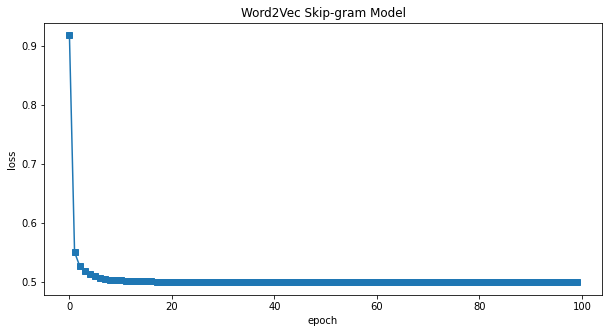

In [10]:
# visualization loss

plt.figure(figsize=(10, 5))
plt.plot(lst_loss, marker='s')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Word2Vec Skip-gram Model')
plt.show()

In [11]:
#計算字詞相似度

def get_similarity(word, top_k, model, word2idx, idx2word):
    W = (model.in_embedding.weight.data + model.out_embedding.weight.data) / 2
    idx = word2idx.get(word, None)
    
    if not idx:
        # 當出現不在字典中的字詞時，顯示Out of vocabulary error
        raise ValueError("Out of vocabulary")
    else:
        x = W[idx]
        
        # 使用cosine相似計算字詞間的相似程度
        cos = torch.matmul(W, x) / (torch.sum(W * W, dim=-1) * torch.sum(x * x) + 1e-9).sqrt()
        _, topk = torch.topk(cos, top_k+1)
        
        for i in topk[1:]:
            print(f"cosine sim={cos[int(i)]:.3f}: {idx2word[int(i)]}.")

get_similarity('love', 4, model, word2idx, idx2word)

cosine sim=0.342: burnham.
cosine sim=0.332: natural-gas.
cosine sim=0.325: egyptian.
cosine sim=0.322: chose.
